In [73]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

IMAGE_PATHS = ["registered_7.nii.gz", "registered_11to7.nii.gz"]
# IMAGE_PATHS = ["registered_1.nii.gz", "registered_11to1.nii.gz"]
SPACING = 0.5
ALPHA = 0.5
BLACK = float(0)

def load_image(image_path):
    return sitk.ReadImage(image_path, sitk.sitkFloat32)

def load_arr(image):
    return sitk.GetArrayFromImage(image)

def is_image(fused_image_current, original_image_array):
    (x1, y1, z1) = fused_image_current
    (x2, y2, z2) = original_image_array.shape

    if not (x2 - 1 > x1 and y2 - 1 >  y1 and z2 -1 > z1):
        return False

    if original_image_array[x1, y1, z1] == BLACK:
        return False

    return True

def set_point(x, y, z, value, fused_image):
    fused_image.SetPixel(int(x), int(y), int(z), int(value))


In [74]:
# set up images
images = [load_image(image_path) for image_path in IMAGE_PATHS]
arrs = [load_arr(image) for image in images]
sizes = [image.GetSize() for image in images]
origins = [image.GetOrigin() for image in images]
spacing = [image.GetSpacing() for image in images]

# size of fused image in world coordinates
size_fused = max([image.TransformIndexToPhysicalPoint(size) for (image, size) in zip(images, sizes)])

# origin of fused image in world coordinates
origin_fused = min([image.TransformIndexToPhysicalPoint((int(origin[0]), int(origin[1]), int(origin[2]))) for (image, origin) in zip(images, origins)])

# size of fused image in fused image coordinates
size_fused_index = images[-1].TransformPhysicalPointToIndex(size_fused)
    

In [78]:
print(sizes)
print(sizes[0])
print(arrs[0].shape)
print(arrs[1].shape)
print(origins)
print("origin fused: ", origin_fused)
print("size fused: ", size_fused)
print("size fused index: ", size_fused_index)

[(193, 370, 234), (289, 405, 258)]
(193, 370, 234)
(234, 370, 193)
(258, 405, 289)
[(-48.23124694824219, -92.39669799804688, 46.795082092285156), (-42.835182189941406, -120.43326568603516, 39.85711669921875)]
max fused:  (101.6648178100586, 82.06673431396484, 168.85711669921875)
origin fused:  (-72.23124694824219, -138.39669799804688, 69.79508209228516)
size fused:  (101.6648178100586, 82.06673431396484, 168.85711669921875)
size fused index:  (289, 405, 258)


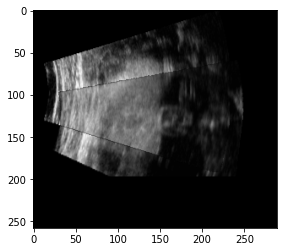

In [66]:
# create fused image
fused_image = sitk.Image(size_fused_index, sitk.sitkFloat32)
fused_image.SetOrigin(origin_fused)
fused_image.SetSpacing((SPACING, SPACING, SPACING))
    
# not sure what this does but it is from original code
fused_origin_index = fused_image.TransformPhysicalPointToIndex((origin_fused))
fused_max_index = fused_image.TransformPhysicalPointToIndex(size_fused)

for x in np.arange(fused_origin_index[0], fused_max_index[0] - 1):
    for y in np.arange(fused_origin_index[1], fused_max_index[1] - 1):
        for z in np.arange(fused_origin_index[2], fused_max_index[2] - 1):
            if is_image((x, y, z), arrs[0]) and is_image((x, y, z), arrs[1]):
                value = ALPHA * arrs[0][x, y, z] + (1 - ALPHA) * arrs[1][x, y, z]
                set_point(x, y, z, value, fused_image)
            elif is_image((x, y, z), arrs[0]):
                value = arrs[0][x, y, z]
                set_point(x, y, z, value, fused_image)
            elif is_image((x, y, z), arrs[1]):
                value = arrs[1][x, y, z]
                set_point(x, y, z, value, fused_image)

# image output
fused_arr = sitk.GetArrayFromImage(fused_image)
slice_fused_image = fused_arr[:,200,:]
plt.imshow(slice_fused_image,'gray')
plt.show()